# MFLES

MFLES is a simple time series method based on gradient boosting time series decomposition. There are numerous methods that can enter the boosting loop depending on user-provided parameters or some quick logic MFLES does automatically that seems to work ok. Some of these methods are:
1. SES ensemble
2. Simple Moving Average
3. Simple Linear Trend
4. Piecewise Linear Trend
4. Fourier Basis function regression for seasonality
5. Simple Median
6. Median per Season
7. A Robust Linear method for trend

#The MFLES Objective
The objective is two fold:
1. I wanted to learn Numba, so the backend is mostly written in Numba and it is pretty fast.
2. I wanted MFLES to be an extremely flexible model depending on parameters but also give reasonable results based on default values and ultimately be another useful stat model to throw in your bag of models.

# Fitting MFLES
Fitting with default values is pretty simple, the only thing to note is that everything with MFLES uses numpy arrays. Also, as with all Numba based backends, the initial run compiles the functions and can take some time. Subsequent calls are much snappier!

In [1]:
pip install MFLES --upgrade

  Attempting uninstall: MFLES
    Found existing installation: MFLES 0.1.5
    Uninstalling MFLES-0.1.5:
      Successfully uninstalled MFLES-0.1.5


/usr/local/lib/python3.10/dist-packages/MFLES/Model.py:17: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def lasso_nb(X, y, alpha, tol=0.001, maxiter=10000):
/usr/local/lib/python3.10/dist-packages/MFLES/Model.py:174: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def median(y, seasonal_period):
/usr/local/lib/python3.10/dist-packages/MFLES/Model.py:190: NumbaDep

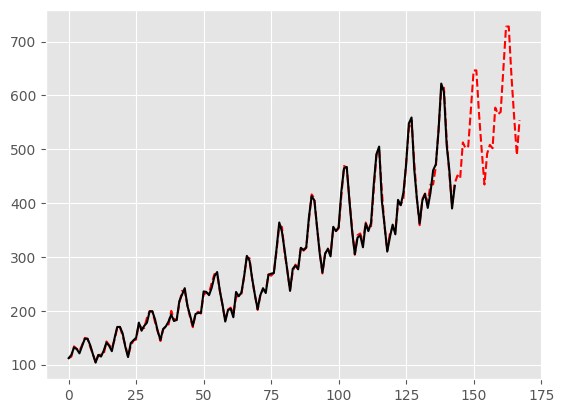

In [2]:
import pandas as pd
from MFLES.Forecaster import MFLES

df = pd.read_csv(r'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
y = df['Passengers'].values # make array


mfles = MFLES()
fitted = mfles.fit(y, seasonal_period=12) #Just pass the expected seasonal period
predicted = mfles.predict(24) #Pass the forecast horizon
mfles.plot() #Plot the results

# Trend/Seasonal Decomposition and Some Useful Parameters
Pass the same things as you would to fit, trend here is composed of both linear and moving average / SES Ensemble pieces. Could split them out if desired since most people want smoother trends to look at.

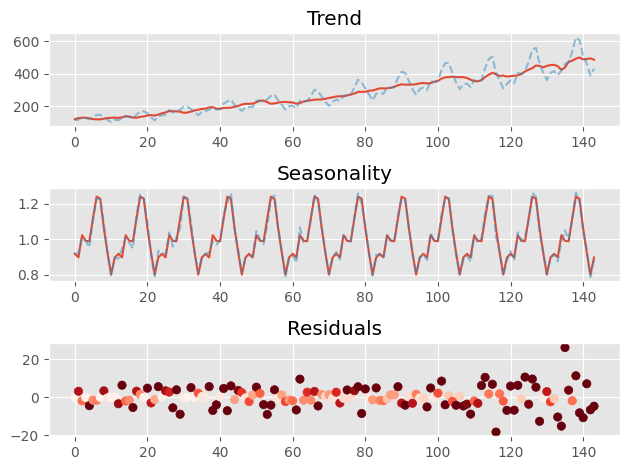

In [3]:
mfles = MFLES()
decomposition = mfles.seasonal_decompose(y, seasonal_period=12) #returns a dict of the components
mfles.plot_decomposition()

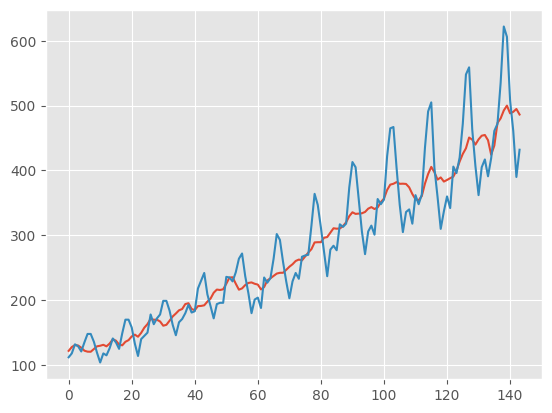

In [4]:
import matplotlib.pyplot as plt
plt.plot(decomposition['trend'], label='Trend')
plt.plot(y, label='Original')
plt.show()

You can smoothen this out manually by adjusting the MA smoothing of the residuals by using the ma parameter:

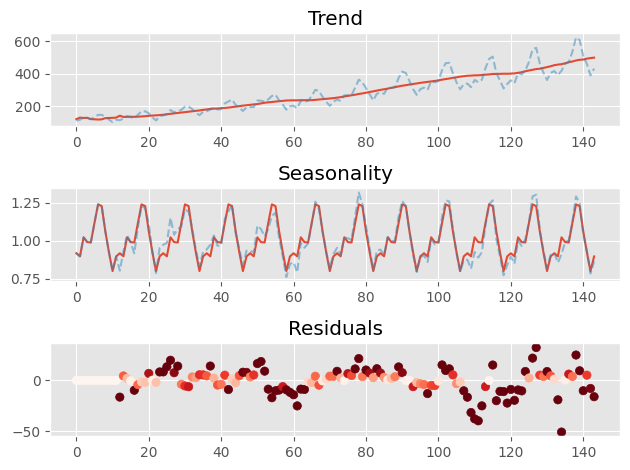

In [5]:
mfles = MFLES()
decomposition = mfles.seasonal_decompose(y,
                                         seasonal_period=12,
                                         ma=12 #This parameter controls the lookback window for the simple moving average
                                         )
mfles.plot_decomposition()

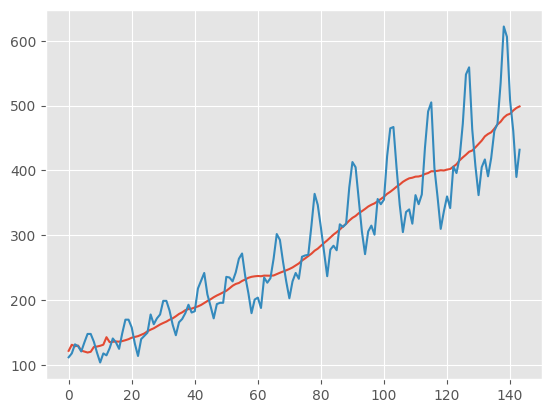

In [6]:
import matplotlib.pyplot as plt
plt.plot(decomposition['trend'], label='Trend')
plt.plot(y, label='Original')
plt.show()

Additionally, we can penalize the error smoothing component

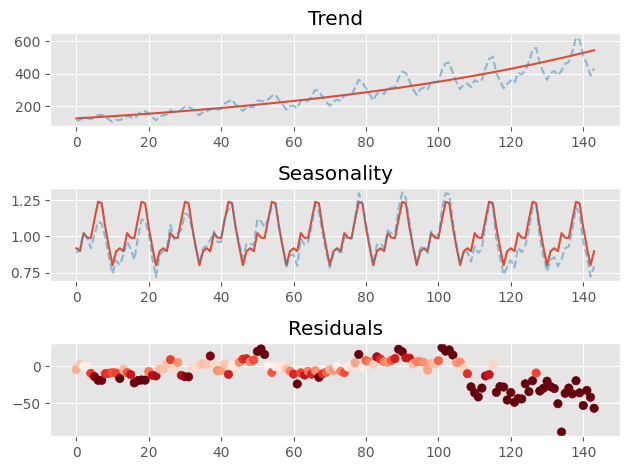

In [8]:
mfles = MFLES()
decomposition = mfles.seasonal_decompose(y,
                                         seasonal_period=12,
                                         rs_lr=0.0 #This parameter controls the residual smoothing, here we set it to 0 which means it will not be used at all! Default is 1.0 and just pass something between 0 and 1
                                         )
mfles.plot_decomposition()

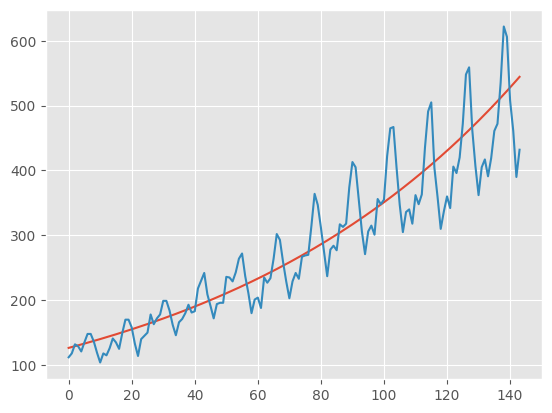

In [9]:
import matplotlib.pyplot as plt
plt.plot(decomposition['trend'], label='Trend')
plt.plot(y, label='Original')
plt.show()

The trend doesn't look great, looks like it is just a simple log-trend. We can force changepoints by changing the cov_threshold parameter which controls overall robustness:

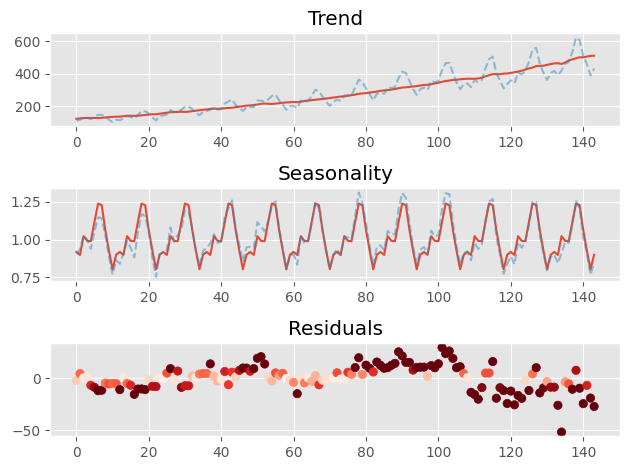

In [15]:
mfles = MFLES()
decomposition = mfles.seasonal_decompose(y,
                                         seasonal_period=12,
                                         rs_lr=0.3, #This parameter controls the residual smoothing, here we set it to 0.3 which will allow some non-smoothness in the trend
                                         cov_threshold=-1, #This parameter controls whether we use robust methods or not, setting it to -1 means we will not do any 'safe' fitting settings
                                         )
mfles.plot_decomposition()

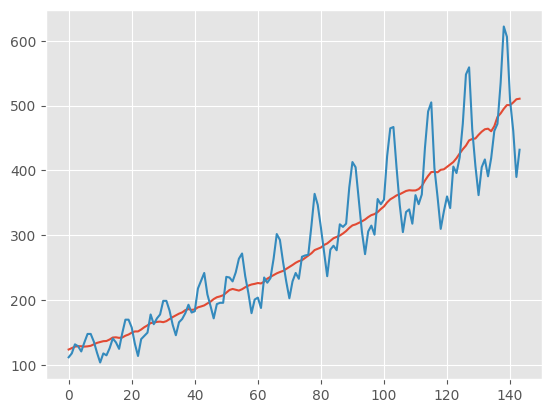

In [16]:
import matplotlib.pyplot as plt
plt.plot(decomposition['trend'], label='Trend')
plt.plot(y, label='Original')
plt.show()

Trend looks a little better but it is still multiplicative so hard to tell

# Multiple Seasonality
Just pass a list! In this example it is kind of dumb to do this but we will do it anyway.

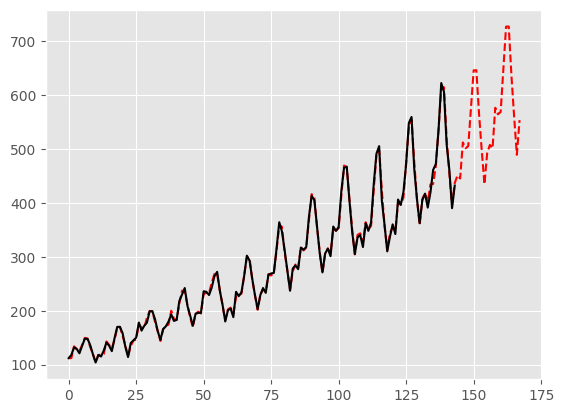

In [21]:
mfles = MFLES()
fitted = mfles.fit(y, seasonal_period=[12, 4, 3]) #Just pass the expected seasonal period
predicted = mfles.predict(24) #Pass the forecast horizon
mfles.plot() #Plot the results

# Conformal Prediction Intervals

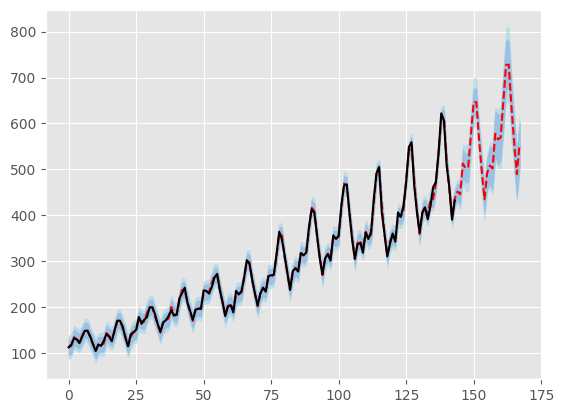

In [22]:
mfles = MFLES()
#the conformal method will roll through the training data and generate prediction errors to use for intervals.
point_estimates, upper_bound, lower_bound = mfles.conformal(y,
                                                            forecast_horizon=24, #your forecast horizon, used to generate the horizon specific errors. Could pop errors if too long compared to history
                                                            n_windows=30, #Number of samples to generate, Can pop error if too high relative to series length
                                                            coverage=[.7,.9], #the desired coverage / coverages
                                                            seasonal_period=12) #kwargs to pass to the fit

mfles.plot() #calling plot now uses the intervals